# Task 1

## Problem Statement
Implement, on a quantum simulator of your choice, the following 4 qubits state $|\psi(\theta)>$:

![circuit.png](https://raw.githubusercontent.com/codewithsk/qosf-f20/master/assets/circuit.png)

Where the number of layers, denoted with L, has to be considered as a parameter. We call ¨Layer¨ the combination of 1 yellow + 1 green block, so, for example, U1 + U2 is a layer. The odd/even variational blocks are given by:


Even blocks:
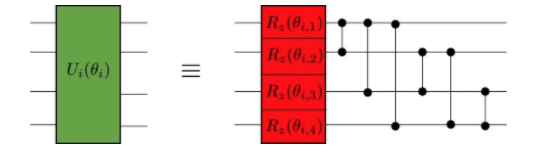


Odd blocks:
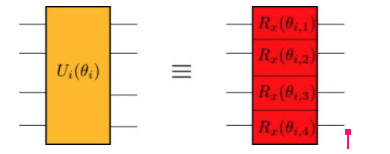



The angles $\theta_{i,n}$ are variational parameters, lying in the interval $(0, 2\pi)$, initialized at random. Double qubit gates are CZ gates.

Report with a plot, as a function of the number of layers, L, the minimum distance

$$
\varepsilon=\min _{\theta}\||\psi(\theta)>-| \varphi>\|
$$

Where $| \varphi>$ is a randomly generated vector on 4 qubits and the norm $|| | v> ||$, of a state $| v>$, simply denotes the sum of the squares of the components of $|v >$. The right set of parameters $i,n$ can be found via any method of choice (e.g. grid-search or gradient descent)

## Solution

We want to find how the cost function $\varepsilon$ changes with the increase in number of layers, when each layer has the most optimal set of weights.


We can use optimizers from [Pennylane](https://pennylane.ai/) to find the most optimal weights at each layer.

In [61]:
%matplotlib inline
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os

### Step 1: Set configuration values

We set the default values for the number of layers, qubits and optimization steps. We set an output directory for where we want to store the results of our experiment

In [62]:
NUM_LAYERS = 1
NUM_QUBITS = 4
NUM_STEPS = 250

STEP_SIZE = 0.1

OUTPUT_DIR = "./output/"

qpu = qml.device("default.qubit", wires=NUM_QUBITS)

We generate the random state vector that we want to optimize for

In [63]:
psi = np.random.rand(2**NUM_QUBITS)
while sum(psi) !=1:
    psi = np.random.rand(2**NUM_QUBITS)
    psi = np.exp(psi) / sum(np.exp(psi))

print(psi)

[0.09152723 0.05742323 0.03894548 0.04908933 0.06294196 0.06071669
 0.06999356 0.08585    0.05010676 0.06074506 0.05718456 0.06314831
 0.07975987 0.06996583 0.0529361  0.04966604]


### Step 2: Define helper function for generating circuit

The params for each layer are indexed as ```params[layer_index * total_qubits + qubit_under_consideration]```


In [64]:
@qml.qnode(qpu)
def circuit(params):

    global NUM_LAYERS
    global NUM_QUBITS
    
    for layer in range(NUM_LAYERS):
        for wire in range(NUM_QUBITS):
            qml.RZ(params[layer * NUM_QUBITS + wire] * np.pi, wires=wire)
            
        for control in range(NUM_QUBITS-1):
            for target in range(control+1, NUM_QUBITS):
                qml.CZ(wires=[control,target]) 
        
        for wire in range(NUM_QUBITS):
            qml.RX(params[layer * NUM_QUBITS + wire + NUM_QUBITS//2] * np.pi, wires=wire)

    return qml.probs(np.arange(NUM_QUBITS))

let's verify that the single layer circuit we can generate using the above function is the circuit we want

In [65]:
weights = np.random.rand(NUM_LAYERS * NUM_QUBITS * 2)
circuit(weights)
print(circuit.draw())

 0: ──RZ(2.643)──╭C──╭C──────╭C───RX(0.479)─────────────────────────╭┤ Probs 
 1: ──RZ(1.645)──╰Z──│───╭C──│───╭C───────────RX(0.121)─────────────├┤ Probs 
 2: ──RZ(0.479)──────╰Z──╰Z──│───│───────────╭C──────────RX(2.194)──├┤ Probs 
 3: ──RZ(0.121)──────────────╰Z──╰Z──────────╰Z──────────RX(2.145)──╰┤ Probs 



### Step 3: Define the cost function


The cost function we want to use is $$\Sigma_{i=1}^{2^n}({\psi_i - \varepsilon_i})^2$$


In [66]:
def cost(x):
    return np.sum(np.square(circuit(x) - psi))

### Step 4: Optimize to find best parameters

Saving output to ./output/1600228618.293382


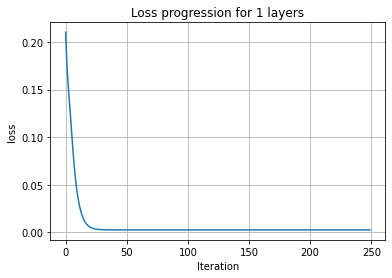

Number of layers: 1, Optimal cost: 0.0024185912686248805, Time: 5.933088064193726s


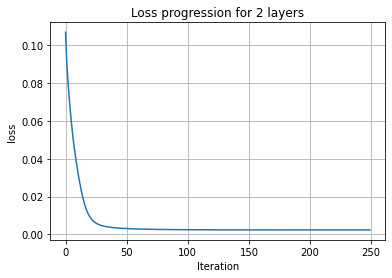

Number of layers: 2, Optimal cost: 0.0023405751136448454, Time: 17.4050030708313s


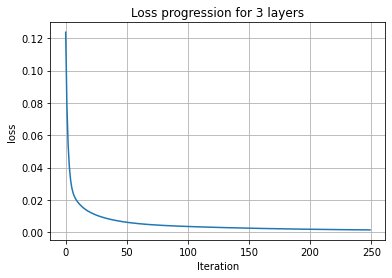

Number of layers: 3, Optimal cost: 0.0013918334081584167, Time: 34.63030004501343s


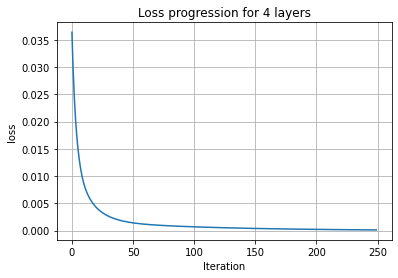

Number of layers: 4, Optimal cost: 0.00012566272349450976, Time: 56.4677460193634s


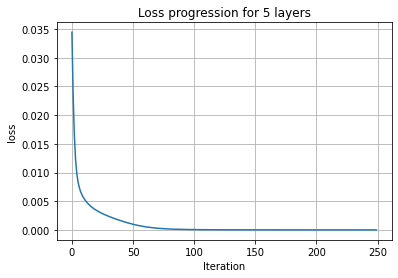

Number of layers: 5, Optimal cost: 7.882260075527843e-07, Time: 83.74219107627869s


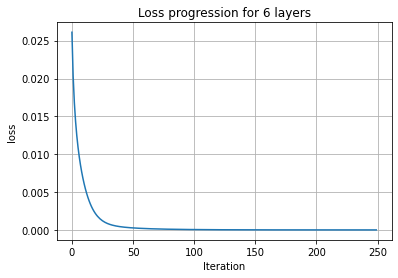

Number of layers: 6, Optimal cost: 3.8734068762217495e-07, Time: 117.69714188575745s


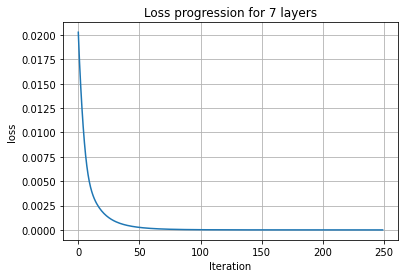

Number of layers: 7, Optimal cost: 1.9433929851271484e-07, Time: 157.2807309627533s


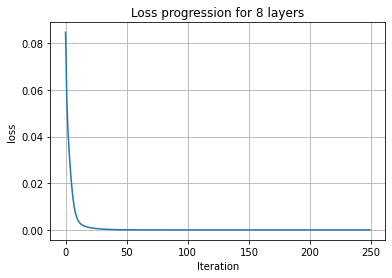

Number of layers: 8, Optimal cost: 1.5029621683528012e-14, Time: 202.7557168006897s


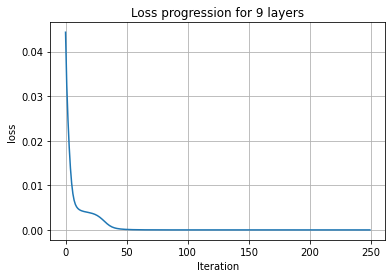

Number of layers: 9, Optimal cost: 3.004321559038047e-13, Time: 252.7429919242859s


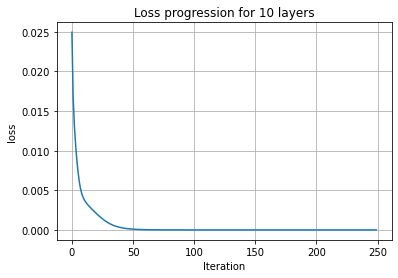

Number of layers: 10, Optimal cost: 2.7560039313819736e-14, Time: 315.8470709323883s


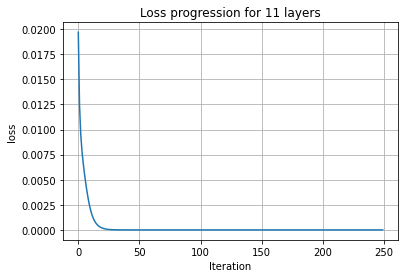

Number of layers: 11, Optimal cost: 2.515089226460617e-18, Time: 380.0548689365387s


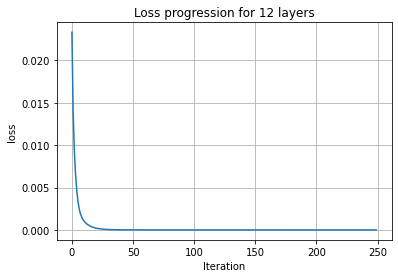

Number of layers: 12, Optimal cost: 1.6560008067783662e-15, Time: 460.7555019855499s


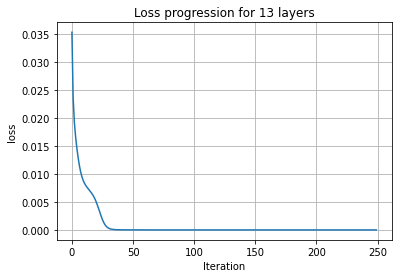

Number of layers: 13, Optimal cost: 8.803874935087787e-16, Time: 534.047219991684s


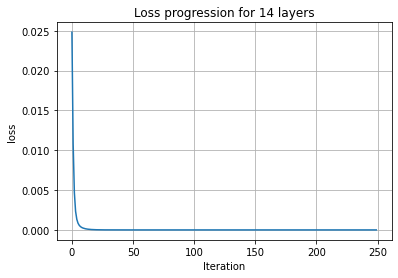

Number of layers: 14, Optimal cost: 3.814083029545481e-25, Time: 611.0256578922272s


<Figure size 432x288 with 0 Axes>

In [67]:
loss = []
times = []

overall_begin = time.time()

output_file_path = os.path.join(OUTPUT_DIR, str(overall_begin))
os.mkdir(output_file_path)

print(f"Saving output to {output_file_path}")

for layers in range(1,15):
    # We use the gradient descent optimizer
    opt = qml.GradientDescentOptimizer(stepsize=STEP_SIZE)
    
    # Iterate through powers of 2
    #NUM_LAYERS=2**layers
    NUM_LAYERS=layers
    
    # Randomly initialize weights
    params = np.random.uniform(low=0, high=2, size=NUM_LAYERS * NUM_QUBITS * 2)

    local_loss = []
    begin = time.time()
    for i in range(NUM_STEPS):
        params = opt.step(cost, params)
        local_loss.append(cost(params))
    end = time.time()

    # Plot the loss for this layer
    plt.xscale('linear')
    plt.xlabel('Iteration')
    plt.ylabel('loss')
    plt.grid(True)
    plt.title(f"Loss progression for {NUM_LAYERS} layers")
    plt.plot(local_loss)
    plt.savefig(os.path.join(output_file_path, str(NUM_LAYERS) + ".png"))
    plt.show()
    plt.clf()
    
    # Save the most optimal circuit
    with open(os.path.join(output_file_path, str(NUM_LAYERS) + ".circuit"), 'w') as fp:
        circuit(params)
        fp.write(circuit.draw())
    
    local_runtime = end - begin
    times.append(local_runtime)
    
    loss.append((NUM_LAYERS, local_loss[-1]))
    print("Number of layers: {}, Optimal cost: {}, Time: {}s".format(NUM_LAYERS, local_loss[-1], local_runtime))

Total time taken: 3233.57s


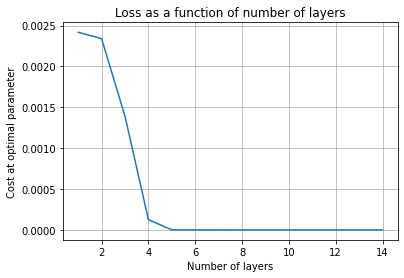

In [68]:
overall_end = time.time()
print(f"Total time taken: {round(overall_end-overall_begin, 2)}s")

# Plot all the losses as a function of the layers
plt.grid(True)
plt.xscale('linear')
plt.xlabel('Number of layers')
plt.ylabel('Cost at optimal parameter')
plt.title(f"Loss as a function of number of layers")
plt.grid(True)
plt.plot(*list(zip(*loss)))
plt.savefig(os.path.join(output_file_path, "overall.png"))

## References
- [Qubit Rotation](https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html)
- [Quantum Natural Gradient](https://pennylane.ai/qml/demos/tutorial_quantum_natural_gradient.html)

## Appendix

### Experiments

Num Steps | Step size | Total Time | Observation | Output Folder
--- | --- | --- | --- | ---
25 | 0.4 | 26mins | Does not converge at higher layer size, Observe oscillating loss | ./output/1600140927.774697
25 | 0.1 | - | Smoother convergence, but looks like loss is sub-optimal, increase number of steps | ./output/1600145563.7758322
100 | 0.1 | 6hrs | Loss converges nicely at each layer setting. Overall, optimal loss seems to not improve beyond ten layers. The spike in layer setting 3 & 7 seem to come from gradient descent not converging, a few more steps should do the trick. Increase num_steps to 150 and check for layers from 1~10 | ./output/1600164935.43664
150 | 0.1 | 10mins | Still observe some spikes at layer setting 3. Looks like layer 4 & 5 could use a few more steps. Final plot doesn't convey stabilized loss, may need to test for a few more layers > 10 to showe that the loss has actually stabilized | ./output/1600164935.43664
250 | 0.1 | 52mins | For each layer setting, the loss seems to be converging smoothly. Overall, the optimal loss does not change after 8 layers. | ./output/1600213048.293647


The above experiments were done with both the odd and even layers having the same parameters. But I just noticed this on the Slack Channel

> Atithi Acharya  9 days ago
> Clarification: Per layer will we have (4+4) different thetas? Or are we supposed to take same set of thetas (thus 4) for both odd and even block since they belong to the same layer i.e. (i) (edited) 

> Dario Rosa  9 days ago
> 4+4


Interesting. So why do the results look reasonable despite using the same parameters for both odd and even layers?


Results for using different parameters are below:

Num Steps | Step size | Total Time | Observation | Output Folder
--- | --- | --- | --- | ---
250 | 0.1 | 52mins | For each layer setting, the loss seems to be converging smoothly. Overall, the optimal loss does not change after 8 layers. | ./output/1600213048.293647